# Weather forecasting with PySpark
## Big Data Computing final project

###Define some global constants

In [0]:
DATASET_PATH: str = 'dbfs:/bigdata_proj/datasets/historical-hourly-weather/'
MODELS_PATH: str = 'dbfs:/bigdata_proj/models/historical-hourly-weather/'

RANDOM_SEED: int = 42

# True to save the computation of datataset preprocessing, fitted pipelines and trained models to the filesystem
SAVE_COMPUTATIONS: bool = True
  
# True to load the sampled dataset from the filesystem, False to compute it from the raw one
LOAD_SAMPLED_DATASET: bool = False
SAMPLED_DATASET_PATH: str = f'{DATASET_PATH}aggregated_sampled_weather_measurements.csv'
  
# True to load the encoding pipeline from the filesystem, False to compute it from scratch
LOAD_ECONDING_PIPELINE: bool = False
ENCODING_PIPELINE_PATH: str = f'{MODELS_PATH}data_encoder'

# True to load pretrained models from the filesystem, False to compute them from scratch
LOAD_PRETRAINED_MODELS: bool = False
RANDOM_FOREST_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest'
RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest_cv'
LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH: str = f'{MODELS_PATH}log_reg_cv'

# necessary due to DataBricks community edition limits (training on a dataframe larger than this threshold causes an Internal Server Error)
MAX_TRAIN_SIZE: int = 999_999

###Import PySpark packages and other dependencies

In [0]:
import pyspark
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel

from typing import *

## Dataset initialization

### Download the dataset
Original source: [kaggle.com/selfishgene/historical-hourly-weather-data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data)

In [0]:
%sh
wget --no-verbose https://github.com/SouravGanesh/BigData_DataSet/raw/main/dataset/historical-hourly-weather-dataset.zip -O /tmp/dataset.zip
unzip -u /tmp/dataset.zip -d /tmp/dataset

2024-03-23 17:21:18 URL:https://raw.githubusercontent.com/SouravGanesh/BigData_DataSet/main/dataset/historical-hourly-weather-dataset.zip [12655281/12655281] -> "/tmp/dataset.zip" [1]


Archive:  /tmp/dataset.zip
   creating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/._committed_7616641238230246128.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00000-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5515-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00006-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5521-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00002-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5517-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00004-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5519-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/part-00003-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413

###Move the dataset from Databricks local driver node's file system to DBFS

In [0]:
for file in dbutils.fs.ls('file:/tmp/dataset'):
    dbutils.fs.mv(file.path, f'{DATASET_PATH}{file.name}', recurse=True)

In [0]:
%fs ls /bigdata_proj/datasets/historical-hourly-weather

path,name,size,modificationTime
dbfs:/bigdata_proj/datasets/historical-hourly-weather/aggregated_sampled_weather_measurements.csv/,aggregated_sampled_weather_measurements.csv/,0,1710607244000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/city_attributes.csv,city_attributes.csv,1614,1711214481000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/humidity.csv,humidity.csv,9075077,1711214481000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/pressure.csv,pressure.csv,12155911,1711214481000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/temperature.csv,temperature.csv,13971171,1711214483000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/weather_description.csv,weather_description.csv,21858089,1711214481000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/wind_direction.csv,wind_direction.csv,10171003,1711214484000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/wind_speed.csv,wind_speed.csv,7457531,1711214480000


###Load dataset into Spark DataFrame objects

### Dataset shape and schema
The raw dataset downloaded from kaggle is composed of 7 different `.csv` files:
- `city_attributes.csv` contains geographical information about the different cities for which there are weather measurements
- `weather_description.csv` contains the textual description of the weather conditions, where each column refers to a different city and each row refers to a specific `datetime` in which the weather condition occurred
- Each one of the other 5 csv follows the same structure as `weather_description.csv` and contains the measurements of the following metrics: `humidity`,  `pressure`, `temperature`, `wind_direction`, `wind_speed`

Except for `city_attributes.csv`, all the other files contains about **45.000** records of hourly weather measurements, that multiplied by the **36** cities results in approximately **1.500.000** records.

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# rest of your code
weather_conditions_df = spark.read.csv(f'{DATASET_PATH}weather_description.csv', header=True, inferSchema=True)
humidity_df = spark.read.csv(f'{DATASET_PATH}humidity.csv', header=True, inferSchema=True)
pressure_df = spark.read.csv(f'{DATASET_PATH}pressure.csv', header=True, inferSchema=True)
temperature_df = spark.read.csv(f'{DATASET_PATH}temperature.csv', header=True, inferSchema=True)
city_attributes_df = spark.read.csv(f'{DATASET_PATH}city_attributes.csv', header=True, inferSchema=True)
wind_direction_df = spark.read.csv(f'{DATASET_PATH}wind_direction.csv', header=True, inferSchema=True)
wind_speed_df = spark.read.csv(f'{DATASET_PATH}wind_speed.csv', header=True, inferSchema=True)

In [0]:
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def filter_dataframe_by_city_column(dataframe: DataFrame,
                                    city_name: str,
                                    new_column_name: str) -> DataFrame:
    '''
    Args:
        - dataframe: a `DataFrame` with a datetime column and n cities columns,
                     where the records are the related hourly measurements
        - city_name: city name between the ones in the dataframe
        - new_column_name: name to replace the city name
        
    Returns: 
        a new `DataFrame` with:
            - the datetime column
            - a single column of measurements related to the `city_name`
              and renamed as `new_column_name`
    '''
    return dataframe.withColumn(new_column_name, col(city_name)) \
                    .select([DATETIME_COL, new_column_name])

In [0]:
def join_dataframes(dataframes: List[DataFrame], column_name: str) -> DataFrame:
    '''
    Args:
        - dataframse: a list of `DataFrame` to be joined
        - column_name: the column over which the records should be joined
        
    Returns:
        a new dataframes resulting from the join of all the dataframes
        over the `column_name` column
    '''
    joined_df = dataframes[0]

    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, [column_name])

    return joined_df

In [0]:
from pyspark.sql import Row

weather_measurements_df = None

# Collect the rows of city_attributes_df as a list
city_attributes_list = city_attributes_df.collect()

# Iterate over the list of rows from city_attributes_df
for row in city_attributes_list:
    city = row.City
    country = row.Country
    latitude = row.Latitude
    longitude = row.Longitude

    # Compute a list of `DataFrame`, one for each type of measurement in the city
    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temperature_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_direction_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_speed_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_conditions_df, city, WEATHER_CONDITION_COL)
    ]

    # Compute a `DataFrame` that includes all the data about the measurements in the city
    joined_df = join_dataframes(dataframes, DATETIME_COL) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    # Union the `DataFrame` with the ones computed in the previous iterations
    weather_measurements_df = weather_measurements_df.union(joined_df) if weather_measurements_df is not None else joined_df

In [0]:
weather_measurements_df.show(5)

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-01 12:00:00|    NULL|    NULL|         NULL|          NULL|      NULL|             NULL|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 13:00:00|    76.0|    NULL|       284.63|           0.0|       0.0|             mist|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 14:00:00|    76.0|    NULL| 284.62904131|           6.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 15:00:00|    76.0|    NULL|284.626997923|          20.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 16:00:00|    77.0|    NULL|28

In [0]:
for c in weather_measurements_df.columns:
        print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')

Missing values of column `datetime` count: 0
Missing values of column `humidity` count: 28651
Missing values of column `pressure` count: 16680
Missing values of column `temperature` count: 8030
Missing values of column `wind_direction` count: 7975
Missing values of column `wind_speed` count: 7993
Missing values of column `weather_condition` count: 7955
Missing values of column `city` count: 0
Missing values of column `country` count: 0
Missing values of column `latitude` count: 0
Missing values of column `longitude` count: 0


In [0]:
not_null_weather_measurements_df = weather_measurements_df.dropna()
not_null_weather_measurements_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

In [0]:
not_null_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show(truncate=False)

+----------------------------+------+
|weather_condition           |count |
+----------------------------+------+
|fog                         |16185 |
|very heavy rain             |1001  |
|proximity shower rain       |2339  |
|few clouds                  |133685|
|heavy shower snow           |336   |
|light rain                  |127364|
|light intensity drizzle     |8048  |
|light intensity shower rain |3633  |
|broken clouds               |167102|
|overcast clouds             |133778|
|light snow                  |14368 |
|scattered clouds            |143277|
|thunderstorm with heavy rain|396   |
|thunderstorm with light rain|1179  |
|heavy intensity rain        |14075 |
|moderate rain               |43172 |
|light intensity drizzle rain|41    |
|sky is clear                |641577|
|snow                        |3156  |
|light shower snow           |998   |
+----------------------------+------+
only showing top 20 rows



In [0]:
def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    '''
    Args:
        - weather_conditions: an iterable collection of string weather conditions to be aggregated

    Returns:
        a dictionary that goes from the original weather condition name to one among the following:
            - thunderstorm
            - rainy
            - snowy
            - cloudy
            - foggy
            - sunny
    '''
    
    weather_conditions_dict = dict()
  
    for weather_condition in weather_conditions:
  
        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif 'cloud' in weather_condition_lowered:
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            weather_conditions_dict[weather_condition] = 'foggy'
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            weather_conditions_dict[weather_condition] = 'sunny'
            
    return weather_conditions_dict

In [0]:
weather_conditions_all = not_null_weather_measurements_df \
    .select(WEATHER_CONDITION_COL).distinct() \
    .rdd.map(lambda row: row[0]) \
    .collect()

In [0]:
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

In [0]:
weather_measurements_aggregated_df = not_null_weather_measurements_df.replace(weather_conditions_dict)
weather_measurements_aggregated_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

In [0]:
WEATHER_CONDITIONS = set(weather_conditions_dict.values())

weather_measurements_aggregated_df = weather_measurements_aggregated_df \
    .filter(weather_measurements_aggregated_df[WEATHER_CONDITION_COL].isin(WEATHER_CONDITIONS))

In [0]:
weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_COL).count().show()

+-----------------+------+
|weather_condition| count|
+-----------------+------+
|            rainy|202725|
|            snowy| 21283|
|            sunny|641577|
|           cloudy|577842|
|     thunderstorm| 10852|
|            foggy|138707|
+-----------------+------+



In [0]:
weather_measurements_aggregated_df.show(5)

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-02 09:00:00|    87.0|   807.0| 284.59021694|         268.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 10:00:00|    88.0|   849.0|284.588173552|         281.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 11:00:00|    89.0|   890.0|284.586130164|         295.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 12:00:00|    89.0|   932.0|284.584086776|         309.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 13:00:00|    90.0|   973.0|28

In [0]:
def count_weather_condition_occurrences(dataframe: DataFrame, class_name: str) -> int:
    '''
    Args:
        - dataframe: a `DataFrame` which contains a column `WEATHER_CONDITION_COL`
        - class_name: the class name to count the occurences of
        
    Returns:
        the total number of `class_name` occurences inside `dataframe`
    '''
    return dataframe.filter(dataframe[WEATHER_CONDITION_COL] == class_name).count()

In [0]:
def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    '''
    Args:
        - dataframe: a `DataFrame` of weather measurements which contains a column `WEATHER_CONDITION_COL`
        
    Returns:
        a dictionary that goes from a weather condition to its fraction
        that should be sampled in order to match the occurrences of the minority class
    '''

    rainy_cnt = count_weather_condition_occurrences(dataframe, 'rainy')
    snowy_cnt = count_weather_condition_occurrences(dataframe, 'snowy')
    sunny_cnt = count_weather_condition_occurrences(dataframe, 'sunny')
    foggy_cnt = count_weather_condition_occurrences(dataframe, 'foggy')
    cloudy_cnt = count_weather_condition_occurrences(dataframe, 'cloudy')
    thunderstorm_cnt = count_weather_condition_occurrences(dataframe, 'thunderstorm')


    minority_class_cnt = np.min(
        [rainy_cnt, snowy_cnt, sunny_cnt, cloudy_cnt, foggy_cnt, thunderstorm_cnt]
    )

    return {
        'rainy': minority_class_cnt / rainy_cnt if rainy_cnt != 0 else 0,
        'snowy': minority_class_cnt / snowy_cnt if snowy_cnt != 0 else 0,
        'sunny': minority_class_cnt / sunny_cnt if sunny_cnt != 0 else 0,
        'foggy': minority_class_cnt / foggy_cnt if foggy_cnt != 0 else 0,
        'cloudy': minority_class_cnt / cloudy_cnt if cloudy_cnt != 0 else 0,
        'thunderstorm': minority_class_cnt / thunderstorm_cnt if thunderstorm_cnt != 0 else 0
    }

In [0]:
sampled_weather_measurements_df = weather_measurements_aggregated_df.sampleBy(WEATHER_CONDITION_COL,
                                                                           fractions=get_undersampling_fracs(weather_measurements_aggregated_df),
                                                                           seed=RANDOM_SEED)

sampled_weather_measurements_df.persist()

202725
21283
641577
138707
577842
10852
10852


DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

In [0]:
if LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df = spark.read.csv(SAMPLED_DATASET_PATH, header=True, inferSchema=True)
    
if SAVE_COMPUTATIONS and not LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df.write.csv(SAMPLED_DATASET_PATH,
                                              mode='overwrite',
                                              header=True)

In [0]:
sampled_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show()

+-----------------+-----+
|weather_condition|count|
+-----------------+-----+
|            rainy|10706|
|            snowy|10957|
|            sunny|10904|
|           cloudy|10932|
|     thunderstorm|10852|
|            foggy|10848|
+-----------------+-----+



In [0]:
sampled_weather_measurements_df.describe().to_koalas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
humidity,65199,73.74389177748125,20.462927337259973,5.0,100.0
pressure,65199,1017.0727618521756,13.21751268045232,803.0,1100.0
temperature,65199,286.45027203499797,11.968697464520226,243.62,317.35
wind_direction,65199,184.40565039341095,103.6556423122793,0.0,360.0
wind_speed,65199,3.1850488504424916,2.3049061131079083,0.0,35.0
weather_condition,65199,None,None,cloudy,thunderstorm
city,65199,None,None,Albuquerque,Vancouver
country,65199,None,None,Canada,United States
latitude,65199,37.96983814882133,5.800096481216519,25.774269,49.24966


In [0]:
train_df, test_df = sampled_weather_measurements_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_df.persist()
test_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

In [0]:
# necessary due to DataBricks limits (training on a dataframe larger than this threshold causes an Internal Server Error)
train_df = train_df.limit(MAX_TRAIN_SIZE)

In [0]:
print(f'Train set size:  {train_df.count()} instances')
print(f'Test set size:   {test_df.count()} instances')

Train set size:  52008 instances
Test set size:   13191 instances


In [0]:
NUMERICAL_FEATURES = [HUMIDITY_COL,
                      PRESSURE_COL,
                      TEMPERATURE_COL,
                      WIND_DIRECTION_COL,
                      WIND_SPEED_COL,
                      LATITUDE_COL,
                      LONGITUDE_COL]

CATEGORICAL_FEATURES = []

TARGET_VARIABLE_COL = WEATHER_CONDITION_COL
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'

LABEL_COL = 'label'
PREDICTION_COL = 'prediction'

FEATURES_COL = 'features'
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'

In [0]:
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    
    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    model.write().overwrite().save(path)
    print(path)

In [0]:
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:
    '''
    Args:
        - dataframe: the input `DataFrame` to fit the pipeline
        - numerical_features: the list of column names in `dataframe` corresponding to numerical features
        - categorical_features: the list of column names in `dataframe` corresponding to categorical features
        - target_variable: the column name in `dataframe` corresponding to the target variable
        - with_std: whether to scale the data to unit standard deviation or not (True by default)
        - with_mean: whether to center the data with mean before scaling (False by default)

    Returns:
        the encoding pipeline fitted with `dataframe`
    '''
    
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)
    
    # Create a list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers], 
                            handleInvalid='keep')
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features    
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)
    
    # Create a second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)

    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(dataframe)

    return transformer

In [0]:
data_encoder = PipelineModel.load(ENCODING_PIPELINE_PATH) if LOAD_ECONDING_PIPELINE \
               else encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)

In [0]:
if SAVE_COMPUTATIONS and not LOAD_ECONDING_PIPELINE:
    save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/data_encoder-20242303-181104


In [0]:
encoded_train_df = data_encoder.transform(train_df)
encoded_test_df = data_encoder.transform(test_df)

In [0]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

rnd_forest_model = RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)

In [0]:
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

In [0]:
from pyspark.ml.feature import IndexToString

predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

In [0]:
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

In [0]:
def eval_predictions(predictions: DataFrame) -> None:
  
    from sklearn.metrics import precision_score, recall_score, accuracy_score

    labels = predictions.select(LABEL_COL).to_koalas().to_numpy()
    predictions = predictions.select(PREDICTION_COL).to_koalas().to_numpy()

    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(labels, predictions)    

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')

In [0]:
eval_predictions(rnd_forest_predictions)

Accuracy: 0.5120915775907816
Precision: 0.4867130365518806
Recall: 0.5121052740750489
F1-score: 0.49908639104314


In [0]:
def plot_confusion_matrix(predictions_df: DataFrame,
                          normalize: bool = False,
                          title: str = None):
    '''
    Plots a Confusion Matrix computed on the given `DataFrame`
    
    Args:
        - predictions_df: a `DataFrame` that has at least a `TARGET_VARIABLE_COL` and a `PREDICTED_TARGET_VARIABLE_COL`
        - normalize: True to normalize the values in the Confusion Matrix, False otherwise
        - title: optional title to append on top of the plotted Confusion Matrix
    '''
    
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    labels = predictions_df.select(TARGET_VARIABLE_COL).to_koalas().to_numpy()
    pedictions = predictions_df.select(PREDICTED_TARGET_VARIABLE_COL).to_koalas().to_numpy()

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, pedictions, labels=None)
    
    # Only use the labels that appear in the data
    classes = unique_labels(labels, pedictions)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,           
           xlabel='Predicted label', ylabel='True label',
           title=title)

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()


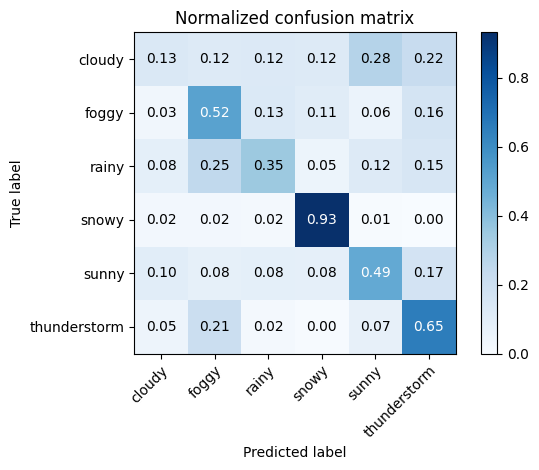

In [0]:
plot_confusion_matrix(rnd_forest_predictions, normalize=True)

In [0]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/rnd_forest-20242303-181500


In [0]:
def random_forest_pipeline(dataframe: DataFrame,
                           numerical_features: List[str],
                           categorical_features: List[str],
                           target_variable: str,
                           features_col: str,
                           with_std: bool = True,
                           with_mean: bool = False,
                           k_fold: int = 5) -> CrossValidatorModel:
  
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline
  
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    classifier = RandomForestClassifier(featuresCol=features_col, labelCol=LABEL_COL)
    
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    stages = [data_encoder, classifier, predictions_idx_to_str]

    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for maxDepth and 3 values for numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxDepth, [3, 5, 8]) \
        .addGrid(classifier.numTrees, [10, 50, 100]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    cv_model = cross_val.fit(dataframe)

    return cv_model

In [0]:
rnd_forest_cv_model = CrossValidatorModel.load(RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                      else random_forest_pipeline(train_df,
                                                  NUMERICAL_FEATURES,
                                                  CATEGORICAL_FEATURES,
                                                  TARGET_VARIABLE_COL,
                                                  FEATURES_COL)

In [0]:
rnd_forest_cv_model_obj = rnd_forest_cv_model.bestModel.stages[-2]._java_obj

print('Best model according to k-fold cross validation:')
print(f' - numTrees=[{rnd_forest_cv_model_obj.getNumTrees()}]')
print(f' - maxDepth=[{rnd_forest_cv_model_obj.getMaxDepth()}]')

Best model according to k-fold cross validation:
 - numTrees=[100]
 - maxDepth=[8]


In [0]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_cv_model, RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/rnd_forest_cv-20242303-182753


In [0]:
rnd_forest_cv_predictions = rnd_forest_cv_model.transform(test_df)

In [0]:
eval_predictions(rnd_forest_cv_predictions)

Accuracy: 0.5424910924114927
Precision: 0.524164633555607
Recall: 0.5425256986247149
F1-score: 0.533187140513149


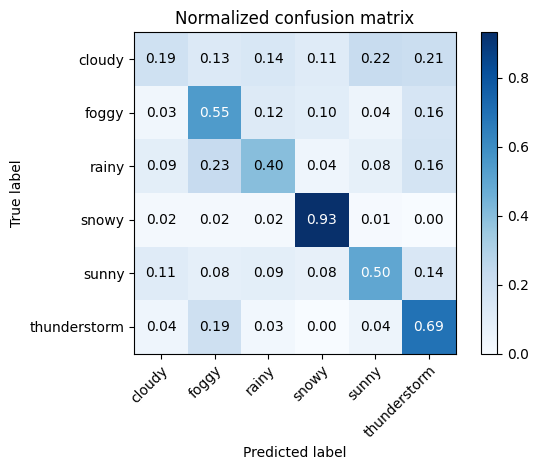

In [0]:
plot_confusion_matrix(rnd_forest_cv_predictions, normalize=True)

In [0]:
def logistic_regression_pipeline(dataframe: DataFrame,
                                 numerical_features: List[str],
                                 categorical_features: List[str],
                                 target_variable: str,
                                 features_col: str,
                                 with_std: bool = True,
                                 with_mean: bool = False,
                                 k_fold: int = 5) -> CrossValidatorModel:
  
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline
  
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    classifier = LogisticRegression(featuresCol=features_col, labelCol=LABEL_COL)
    
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    stages = [data_encoder, classifier, predictions_idx_to_str]

    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for regParam, 3 values for maxIter and 3 values for elasticNetParam,
    # this grid will have 3 x 3 x 3 = 12 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
        .addGrid(classifier.maxIter, [10, 100, 1000]) \
        .addGrid(classifier.regParam, [0.0, 0.05, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    cv_model = cross_val.fit(dataframe)

    return cv_model

In [0]:
log_reg_cv_model = CrossValidatorModel.load(LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                   else logistic_regression_pipeline(train_df,
                                                     NUMERICAL_FEATURES,
                                                     CATEGORICAL_FEATURES,
                                                     TARGET_VARIABLE_COL,
                                                     FEATURES_COL)

In [0]:
log_reg_cv_model_obj = log_reg_cv_model.bestModel.stages[-2]._java_obj

print('Best model according to k-fold cross validation:')
print(f' - regParam=[{log_reg_cv_model_obj.getRegParam()}]')
print(f' - elasticNetParam=[{log_reg_cv_model_obj.getElasticNetParam()}]')
print(f' - maxIter=[{log_reg_cv_model_obj.getMaxIter()}]')

Best model according to k-fold cross validation:
 - regParam=[0.0]
 - elasticNetParam=[0.0]
 - maxIter=[100]


In [0]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(log_reg_cv_model, LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/log_reg_cv-20242303-190059


In [0]:
log_reg_cv_predictions = log_reg_cv_model.transform(test_df)

In [0]:
eval_predictions(log_reg_cv_predictions)

Accuracy: 0.4876051853536502
Precision: 0.4591598501449072
Recall: 0.48731281204462534
F1-score: 0.47281762419736184


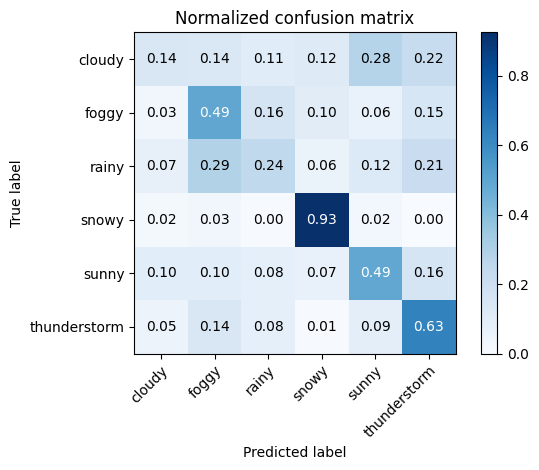

In [0]:
plot_confusion_matrix(log_reg_cv_predictions, normalize=True)

In [0]:
API_KEY = '57fe401be548737b0d267e7abda86175'
CITY_NAMES = ['Vancouver']

openweather_model = rnd_forest_cv_model

OPENWEATHER_FORECAST_COL = 'openweather_forecast'

In [0]:
def get_5_days_forecasts_df(city_name: str, api_key: str) -> DataFrame:

    import requests
  
    spark = SparkSession.builder \
        .appName("WeatherForecast") \
        .getOrCreate()
  
    API_URL = f'http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}'

    res = requests.get(API_URL).json()

    coord = res['city']['coord']

    latitude = float(coord['lat'])
    longitude = float(coord['lon'])
    
    forecasts = []

    for forecast in res['list']:
      
        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather']

        datetime = forecast['dt_txt']
        
        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])

        weather_condition = weather[0]['main']
        
        forecast_row = Row(datetime=datetime,
                           humidity=humidity,
                           pressure=pressure,
                           temperature=temperature,
                           wind_direction=wind_direction,
                           wind_speed=wind_speed,
                           weather_condition=weather_condition,
                           city=city_name,
                           latitude=latitude,
                           longitude=longitude)

        forecasts.append(forecast_row)
        
    return spark.createDataFrame(forecasts)


In [0]:
openweather_forecasts_df = None

for city_name in CITY_NAMES:
    if openweather_forecasts_df is None:
        openweather_forecasts_df = get_5_days_forecasts_df(city_name, API_KEY)
    else:
        openweather_forecasts_df = openweather_forecasts_df.union(get_5_days_forecasts_df(city_name, API_KEY))


In [0]:
weather_conditions = openweather_forecasts_df.select(TARGET_VARIABLE_COL).collect()
weather_conditions_array = [row[0] for row in weather_conditions]
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_array)

In [0]:
openweather_forecasts_df = openweather_forecasts_df.replace(weather_conditions_dict)

In [0]:
openweather_forecasts_df = openweather_forecasts_df.filter(openweather_forecasts_df[TARGET_VARIABLE_COL].isin(WEATHER_CONDITIONS))

In [0]:
openweather_forecasts_df.to_koalas().head(5)

,datetime,humidity,pressure,temperature,wind_direction,wind_speed,weather_condition,city,latitude,longitude
0,2024-03-23 21:00:00,91.0,1002.0,281.67,315.0,1.16,rainy,Vancouver,49.2497,-123.1193
1,2024-03-24 00:00:00,92.0,1002.0,281.29,291.0,2.36,rainy,Vancouver,49.2497,-123.1193
2,2024-03-24 03:00:00,90.0,1003.0,281.10,309.0,2.79,rainy,Vancouver,49.2497,-123.1193
3,2024-03-24 06:00:00,85.0,1004.0,281.32,321.0,2.50,cloudy,Vancouver,49.2497,-123.1193
4,2024-03-24 09:00:00,84.0,1005.0,281.26,319.0,1.77,cloudy,Vancouver,49.2497,-123.1193


In [0]:
openweather_forecasts_predictions = openweather_model.transform(openweather_forecasts_df)

In [0]:
openweather_forecasts_predictions \
    .withColumn(OPENWEATHER_FORECAST_COL, col(TARGET_VARIABLE_COL)) \
    .select([DATETIME_COL, CITY_COL, OPENWEATHER_FORECAST_COL, PREDICTED_TARGET_VARIABLE_COL]) \
    .to_koalas().head(15)

,datetime,city,openweather_forecast,predicted_weather_condition
0,2024-03-23 21:00:00,Vancouver,rainy,rainy
1,2024-03-24 00:00:00,Vancouver,rainy,rainy
2,2024-03-24 03:00:00,Vancouver,rainy,rainy
3,2024-03-24 06:00:00,Vancouver,cloudy,rainy
4,2024-03-24 09:00:00,Vancouver,cloudy,rainy
5,2024-03-24 12:00:00,Vancouver,cloudy,rainy
6,2024-03-24 15:00:00,Vancouver,sunny,rainy
7,2024-03-24 18:00:00,Vancouver,sunny,rainy
8,2024-03-24 21:00:00,Vancouver,cloudy,rainy
9,2024-03-25 00:00:00,Vancouver,cloudy,rainy


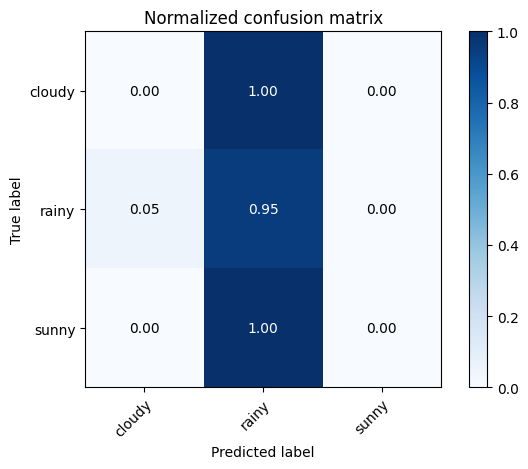

In [0]:
plot_confusion_matrix(openweather_forecasts_predictions, normalize=True) 